In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import matplotlib.pyplot as plt

In [3]:
import rpy2.robjects as robjs
from rpy2.robjects.packages import importr
import statsmodels.api as sm
from IPython.display import display
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
# Import R packages in Python
r = robjs.r
nlme = importr('nlme')
stats = importr('stats')
gstat = importr('gstat')  # Create symlink from anaconda envs tcl to ./lib/tcl
sp = importr('sp')

In [5]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [6]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [7]:
y = yr_avg.values
t1 = yr_avg.year.values

## Piecewise linear regression

### Estimate $\tau$  and fit a seperate regression model

In [8]:
# Initialize fixed set of possible Breakpoints.
T = np.array([1950, 1960, 1970, 1975, 1978, 1979,
              1980, 1985, 1990, 1995, 2000])

In [9]:
# Series split before tau
t_tau_pre = [t1[t1<=tau] for tau in T]
y_tau_pre = [y[t1<=tau] for tau in T]

# Series split after tau
t_tau_post = [t1[t1>tau] for tau in T]
y_tau_post = [y[t1>tau] for tau in T]

In [10]:
# Estimates for pre tau
betahat_pre = []
mse_pre = []
for t_tau, y_tau in zip(t_tau_pre, y_tau_pre):
    robjs.globalenv['y_tau'] = robjs.FloatVector(y_tau)
    robjs.globalenv['t_tau'] = robjs.FloatVector(t_tau)
    fit_tau = r.lm('y_tau ~ t_tau')
    e = fit_tau.rx2('residuals')
    betahat_pre.append(fit_tau.rx2('coefficients'))
    mse_pre.append(np.mean(np.square(np.array(e))))

In [11]:
# Estimates for post tau
betahat_post = []
mse_post = []
for t_tau, y_tau in zip(t_tau_post, y_tau_post):
    robjs.globalenv['y_tau'] = robjs.FloatVector(y_tau)
    robjs.globalenv['t_tau'] = robjs.FloatVector(t_tau)
    fit_tau = r.lm('y_tau ~ t_tau')
    e = fit_tau.rx2('residuals')
    betahat_post.append(fit_tau.rx2('coefficients'))
    mse_post.append(np.mean(np.square(np.array(e))))

In [12]:
# Plot all the pre and posts regressions
regressions_pre = [beta[0] + beta[1]*t_tau_pre[t] for t, beta in enumerate(betahat_pre)]
regressions_post = [beta[0] + beta[1]*t_tau_post[t] for t, beta in enumerate(betahat_post)]

nrows = len(T)
#fig, axs = plt.subplots(nrows, 2, figsize=(30, 30))
#for i, row in enumerate(axs):
#    row[0].plot(y_tau_pre[i])
#    row[0].plot(regressions_pre[i])
#    row[1].plot(y_tau_post[i])
#    row[1].plot(regressions_post[i])

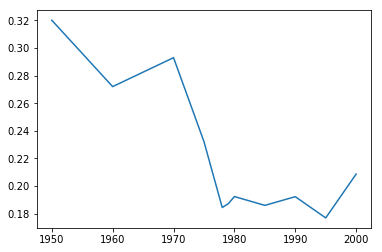

In [13]:
# Visually find the breakpoint with total MSE is at minimum
z = np.array(mse_pre) + np.array(mse_post)
plt.plot(T, z)

In [14]:
# Locate best breakpoint
tau_star = T[np.where(z == np.min(z))][0]
print(tau_star)

1995


In [15]:
# Piecewise linear regression with optimal tau
t_pre = t1[t1<=tau_star]
y_pre = y[t1<=tau_star]
robjs.globalenv['t_pre'] = robjs.FloatVector(t_pre)
robjs.globalenv['y_pre'] = robjs.FloatVector(y_pre)
fit_pre = r.lm('y_pre ~ t_pre')
k_hat_pre = fit_pre.rx2('coefficients')

t_post = t1[t1>=tau_star]
y_post = y[t1>=tau_star]
robjs.globalenv['t_post'] = robjs.FloatVector(t_post)
robjs.globalenv['y_post'] = robjs.FloatVector(y_post)
fit_post = r.lm('y_post ~ t_post')
k_hat_post = fit_post.rx2('coefficients')

In [16]:
t_hat_pre = k_hat_pre[0] + k_hat_pre[1]*t_pre
t_hat_post = k_hat_post[0] + k_hat_post[1]*t_post

In [17]:
def pieces(x, bp): 
    if x <= bp:
        return k_hat_pre[0] + k_hat_pre[1]*x
    else:
        return k_hat_post[0] + k_hat_post[1]*x

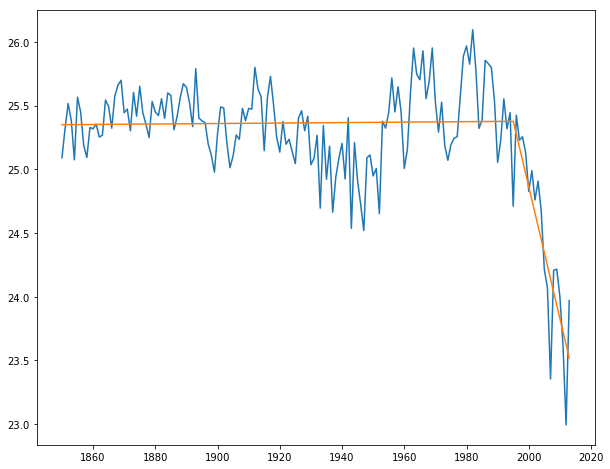

In [18]:
vpieces = np.vectorize(pieces)
y_piecewise = vpieces(t1, tau_star)

fig = plt.figure(figsize=(10, 8))
plt.plot(t1, y)
plt.plot(t1, y_piecewise)

## Linear Splines for Summer months

In [19]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
from patsy import dmatrix

In [24]:
knots = (1893, 1899, 1918, 1943, 1995)
#knots = (1917, 1944, 1995)
knots2 = (1917, 1944, 1995)
transformed_jja = dmatrix('bs(jja_df.year, knots=knots, degree=1, include_intercept=False)',
                          {'jja_df.year': jja_df.year}, return_type='dataframe')
transformed_son = dmatrix('bs(son_df.year, knots=knots2, degree=1, include_intercept=False)',
                          {'son_df.year': son_df.year}, return_type='dataframe')

In [25]:
fit1 = sm.GLM(jja_df.seaice_conc, transformed_jja).fit()
fit2 = sm.GLM(son_df.seaice_conc, transformed_son).fit()

In [26]:
# Generate a sequence of year values spanning the range
year_grid = np.arange(jja_df.year.min(), jja_df.year.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(year_grid, knots=knots, degree=1, include_intercept=False)",
                             {"year_grid": year_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(year_grid, knots=knots2, degree=1, include_intercept=False)",
                             {"year_grid": year_grid}, return_type='dataframe'))

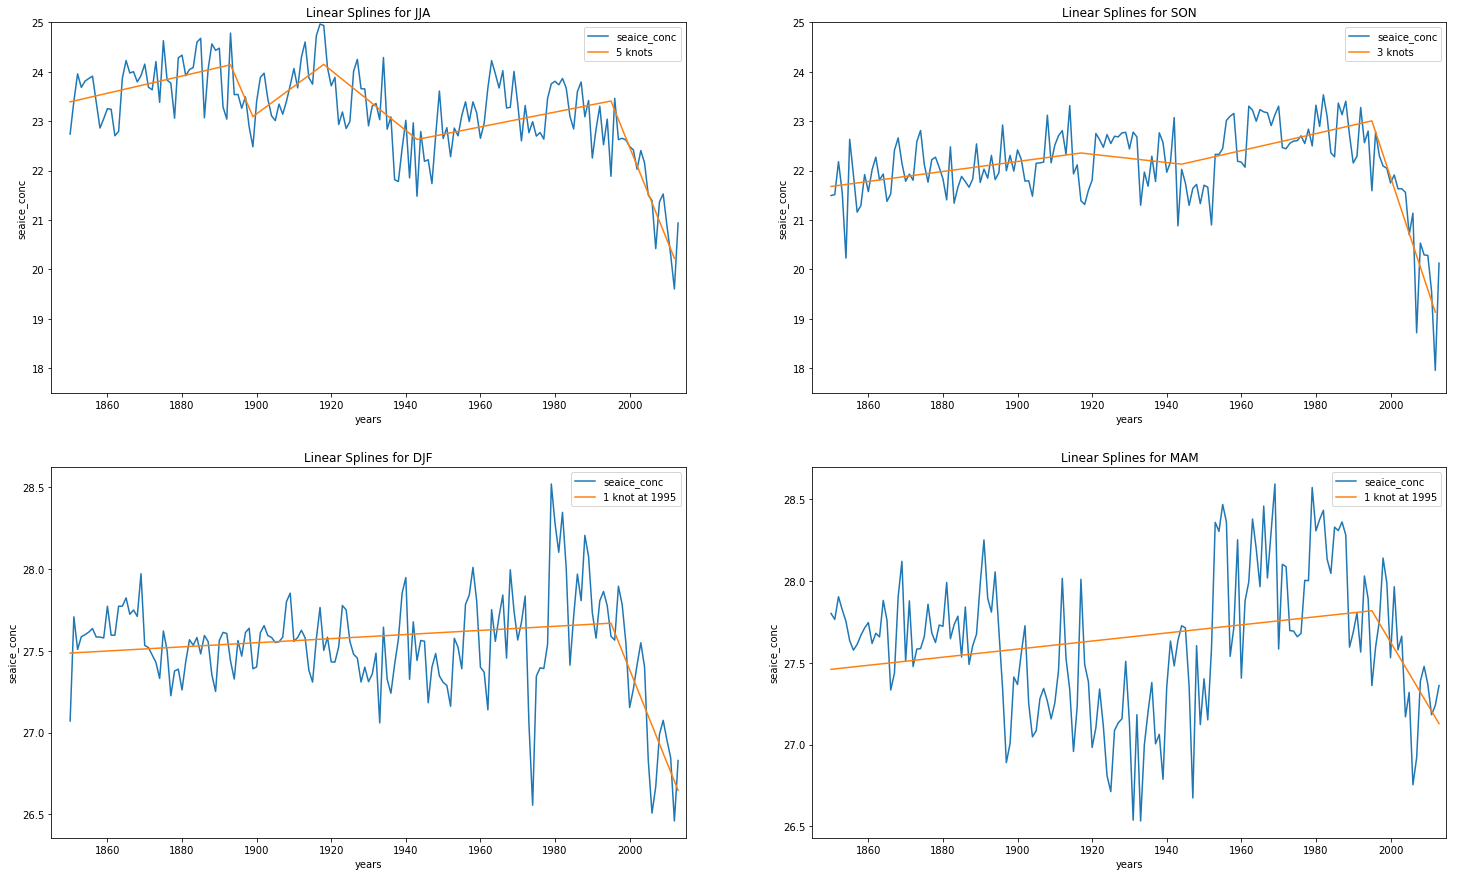

In [27]:
fig, ax = plt.subplots(2,2,figsize=(25,15))    # set up figure and panels

# Plot for JJA
ax[0,0].plot(jja_df.year, jja_df.seaice_conc)
ax[0,0].plot(year_grid, pred1, label='5 knots')
ax[0,0].legend()
ax[0,0].set_xlim(1845, 2015)
ax[0,0].set_ylim(17.5, 25)
ax[0,0].set_xlabel('years')
ax[0,0].set_ylabel('seaice_conc')
ax[0,0].set_title('Linear Splines for JJA')

# Plot for SON
ax[0,1].plot(son_df.year, son_df.seaice_conc)
ax[0,1].plot(year_grid, pred2, label='3 knots')
ax[0,1].legend()
ax[0,1].set_xlim(1845, 2015)
ax[0,1].set_ylim(17.5, 25)
ax[0,1].set_xlabel('years')
ax[0,1].set_ylabel('seaice_conc')
ax[0,1].set_title('Linear Splines for SON')

# Plot for DJF
djf_spl = LSQUnivariateSpline(djf_df.year.values, djf_df.seaice_conc.values, [1995], k=1)
ax[1,0].plot(djf_df.year.values, djf_df.seaice_conc)
ax[1,0].plot(djf_df.year.values, djf_spl(djf_df.year.values), label='1 knot at 1995')
ax[1,0].legend()
ax[1,0].set_xlim(1845, 2015)
ax[1,0].set_xlabel('years')
ax[1,0].set_ylabel('seaice_conc')
ax[1,0].set_title('Linear Splines for DJF')

# Plot for MAM
mam_spl = LSQUnivariateSpline(mam_df.year.values, mam_df.seaice_conc.values, [1995], k=1)
ax[1,1].plot(mam_df.year.values, mam_df.seaice_conc)
ax[1,1].plot(mam_df.year.values, mam_spl(mam_df.year.values), label='1 knot at 1995')
ax[1,1].legend()
ax[1,1].set_xlim(1845, 2015)
ax[1,1].set_xlabel('years')
ax[1,1].set_ylabel('seaice_conc')
ax[1,1].set_title('Linear Splines for MAM')